In [ ]:
import tensorflow

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
import urllib.request

In [ ]:
from PIL import Image
import io,math

In [ ]:
url = 'https://qph.fs.quoracdn.net/main-qimg-f22541ff53f37cb0fbf972c152b95120'

In [ ]:
image = Image.open(urllib.request.urlopen(url))

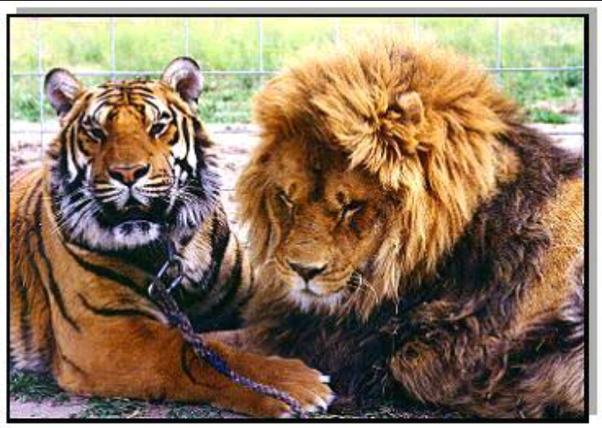

In [ ]:
image

In [ ]:
model = ResNet50(weights = 'imagenet',include_top = True)

In [ ]:
image.size

(602, 428)

In [ ]:
IMAGE = img_to_array(image)

In [ ]:
import PIL
img = load_img(urllib.request.urlopen(url), target_size = (224,224))

In [ ]:
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

In [ ]:
yhat = model.predict(image)
label = decode_predictions(yhat)

In [ ]:
names = []
for i in label[0]:
    names.append(i[1])

In [ ]:
names

['tiger', 'chow', 'lion', 'tiger_cat', 'muzzle']

In [ ]:
import import_ipynb
from data603 import SparkLauncher
from data603 import HDFS

hdfs = HDFS.get_hdfs()

In [ ]:
import os
import pyarrow as pa
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import venv_pack

In [ ]:
import import_ipynb
from data603 import SparkLauncher

# get a configuration object
conf = SparkLauncher.get_spark_conf()

# add a file to the configuration that will get copied to all the nodes on the cluster
conf.set('spark.yarn.dist.files', 'keras_data/mobilenet_1_0_224_tf.h5')

# launch the cluster using the configuration
spark = SparkLauncher.get_spark_session(pack_venv = False, conf = conf)


Creating Spark Configuration
Setting Environment Variables
Creating Spark Session: vamshik1_data603_spark_session


In [ ]:
cats = spark.read.parquet('/user/vamshik1/land_mammals.parquet')

In [ ]:
import pyspark.sql.functions as F
cats = cats.withColumn('LabelText',F.lower(F.col('Label')))

In [ ]:
n = cats.select('LabelText').distinct().collect()

In [ ]:
n

[Row(LabelText='leopard'),
 Row(LabelText='lion'),
 Row(LabelText='cat'),
 Row(LabelText='lynx'),
 Row(LabelText='cheetah'),
 Row(LabelText='tiger')]

In [ ]:
len(names)

5

In [ ]:
n[1]

Row(LabelText='lion')

In [ ]:
import re

In [ ]:
nam = []
for i in range(len(n)):
    alp = ''
    for i in n[i]:
        if i.isalnum():
            alp += i
    alp = re.sub(r'^RowLabelText=*','',alp)
    nam.append(alp)
nam

['leopard', 'lion', 'cat', 'lynx', 'cheetah', 'tiger']

In [ ]:
n[5]

Row(LabelText='tiger')

In [ ]:
cats1 = 0
for i in names:
    if i in nam:
        a = cats.where(cats['LabelText'] == i)
        if type(cats1) == 'pyspark.sql.dataframe.DataFrame':
            cats1 = cats1.union(a)
        else:
            cats1 = a

In [ ]:
type(cats)

pyspark.sql.dataframe.DataFrame

In [ ]:
print(nam,names)

['leopard', 'lion', 'cat', 'lynx', 'cheetah', 'tiger'] ['tiger', 'chow', 'lion', 'tiger_cat', 'muzzle']


In [ ]:
cats1.select('LabelText').distinct().show()

+---------+
|LabelText|
+---------+
|     lion|
+---------+



In [ ]:
cats1.count()

1874

In [ ]:
cats1 = cats1.select(['chip_data','Label'])

In [ ]:
cats1.columns

['chip_data', 'Label']

In [ ]:
def get_ppi(data):
    import math
    import io
    diagonal = 15.4
    img = Image.open(io.BytesIO(data))
    w,h = img.size
    ppi = math.sqrt((w^2)+(h^2))/diagonal
    return ppi

In [ ]:
# make a UDF
from pyspark.sql.types import *
from pyspark.sql.functions import udf

schema = FloatType()

udf_evaluate_chip = udf(get_ppi, schema)

In [ ]:
cats1 = cats1.withColumn("ppi", udf_evaluate_chip("chip_data"))

In [ ]:
cats1.select('ppi').show(5)

+---------+
|      ppi|
+---------+
| 2.274582|
|2.0182168|
|2.5366266|
|  2.86083|
| 2.208747|
+---------+
only showing top 5 rows



----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 53976)
Traceback (most recent call last):
  File "/usr/lib64/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib64/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib64/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib64/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/scratch/data603_virtualenv/vamshik1/lib64/python3.6/site-packages/pyspark/accumulators.py", line 267, in handle
    poll(authenticate_and_accum_updates)
  File "/scratch/data603_virtualenv/vamshik1/lib64/python3.6/site-packages/pyspark/accumulators.py", line 239, in poll
    r, _, _ = select.select([self.rfile], [], [], 1)
ValueError: filedescriptor out of r

In [ ]:
cats1.show(5)

+--------------------+-----+---------+
|           chip_data|Label|      ppi|
+--------------------+-----+---------+
|[FF D8 FF E0 00 1...| Lion| 2.274582|
|[FF D8 FF E0 00 1...| Lion|2.0182168|
|[FF D8 FF E0 00 1...| Lion|2.5366266|
|[FF D8 FF E0 00 1...| Lion|  2.86083|
|[FF D8 FF E0 00 1...| Lion| 2.208747|
+--------------------+-----+---------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import rank
from pyspark.sql import Window
from pyspark.sql.functions import desc
import pyspark.sql.functions as psf

In [ ]:
wA = Window.orderBy(desc("ppi"))

In [ ]:
rank_cats = cats1.withColumn("rank", psf.dense_rank().over(wA))

In [ ]:
rank_cats.show(10)

+--------------------+-----+---------+----+
|           chip_data|Label|      ppi|rank|
+--------------------+-----+---------+----+
|[FF D8 FF E0 00 1...| Lion| 2.941494|   1|
|[FF D8 FF E0 00 1...| Lion| 2.941494|   1|
|[FF D8 FF E0 00 1...| Lion| 2.941494|   1|
|[FF D8 FF E0 00 1...| Lion| 2.941494|   1|
|[FF D8 FF E0 00 1...| Lion|2.9371903|   2|
|[FF D8 FF E0 00 1...| Lion|2.9328804|   3|
|[FF D8 FF E0 00 1...| Lion|2.9264038|   4|
|[FF D8 FF E0 00 1...| Lion| 2.922078|   5|
|[FF D8 FF E0 00 1...| Lion|2.9163003|   6|
|[FF D8 FF E0 00 1...| Lion|2.9119594|   7|
+--------------------+-----+---------+----+
only showing top 10 rows



In [ ]:
rank_cats.count()

1874

In [ ]:
def print_image(data):
    img1 = Image.open(io.BytesIO(data))
    return(img1)

In [ ]:
rand_data = rank_cats.filter(rank_cats.rank.isin([2, 20,500,1000,1100]))

In [ ]:
rand_data.show(5)

+--------------------+-----+----------+----+
|           chip_data|Label|       ppi|rank|
+--------------------+-----+----------+----+
|[FF D8 FF E0 00 1...| Lion| 2.9371903|   2|
|[FF D8 FF E0 00 1...| Lion| 2.8244886|  20|
|[FF D8 FF E0 00 1...| Lion| 2.1320071| 500|
|[FF D8 FF E0 00 1...| Lion| 1.2591376|1000|
|[FF D8 FF E0 00 1...| Lion|0.99119073|1100|
+--------------------+-----+----------+----+



In [ ]:
pd_rand_data = rand_data.toPandas()

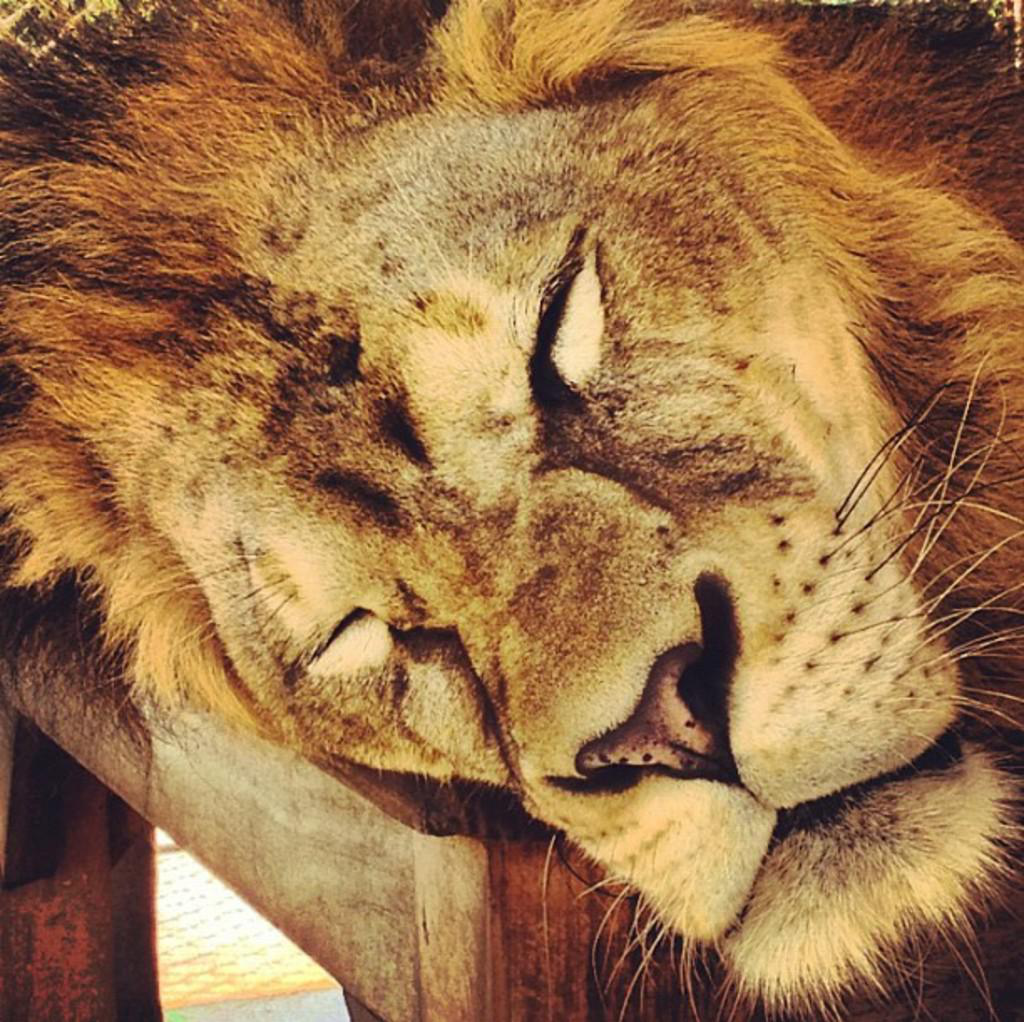

In [ ]:
print_image(pd_rand_data.chip_data[0])

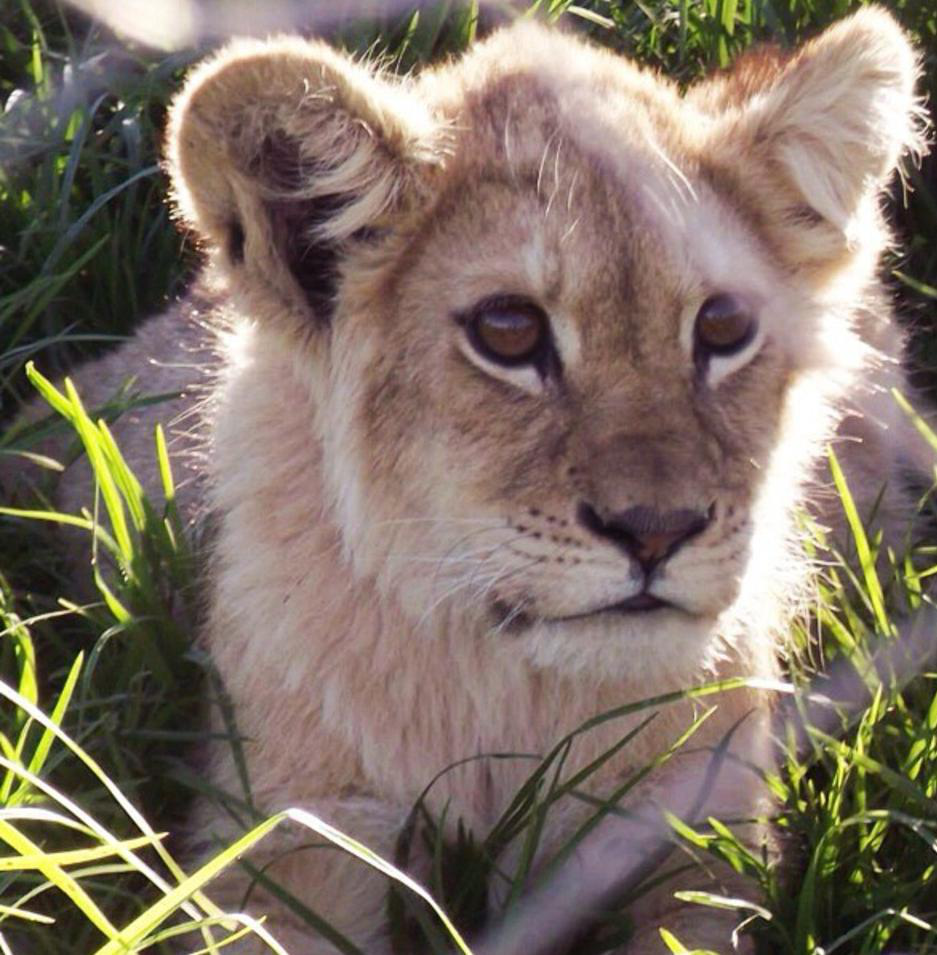

In [ ]:
print_image(pd_rand_data.chip_data[1])

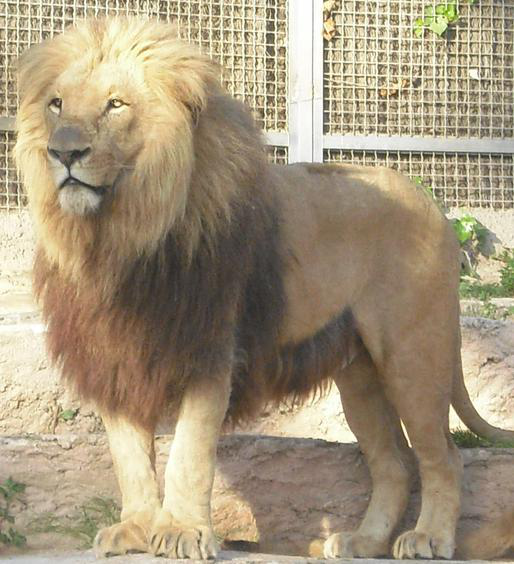

In [ ]:
print_image(pd_rand_data.chip_data[2])

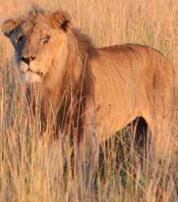

In [ ]:
print_image(pd_rand_data.chip_data[3])

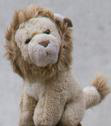

In [ ]:
print_image(pd_rand_data.chip_data[4])